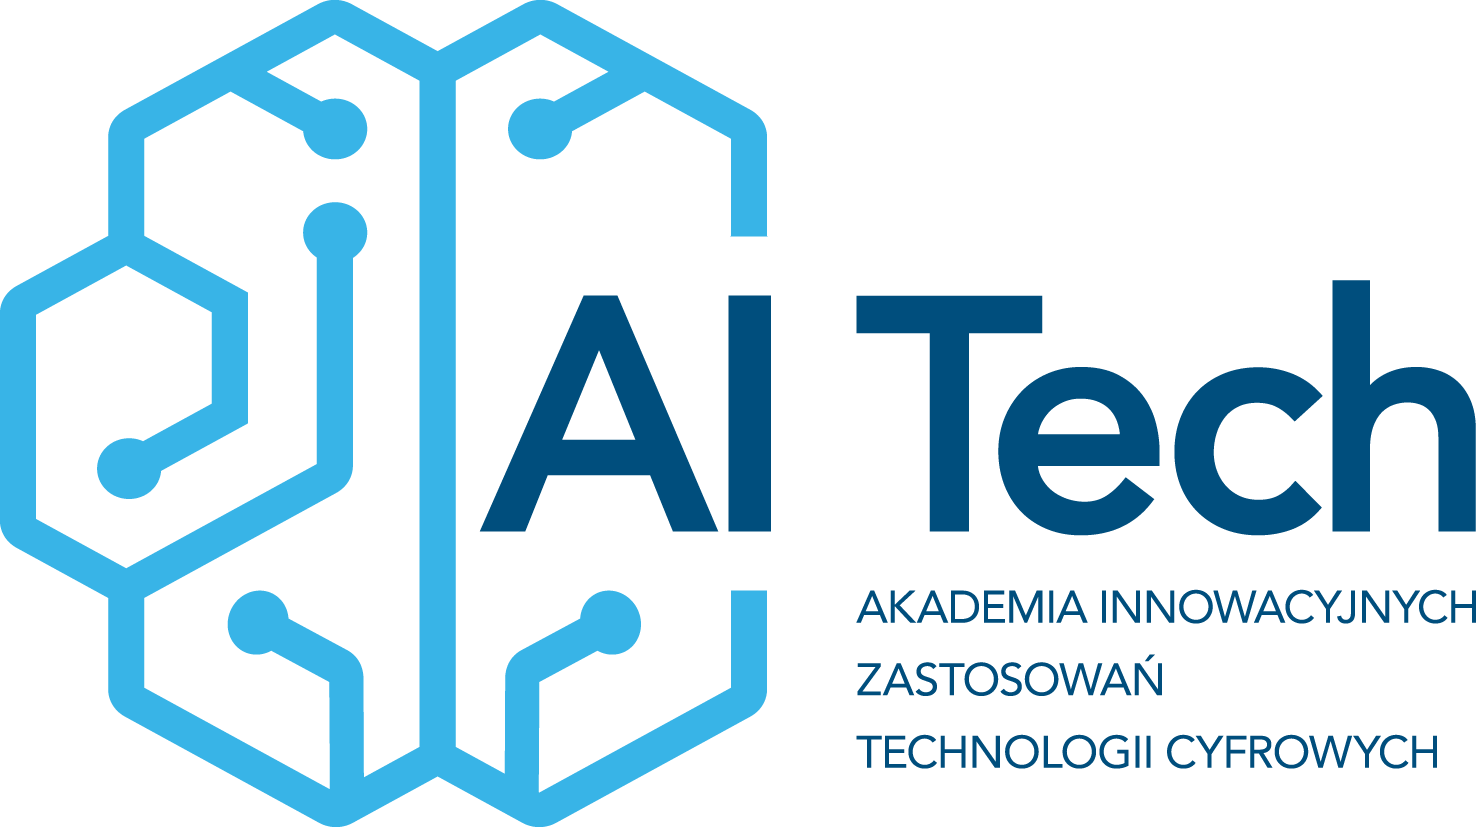



AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<center>
<br>
<br>
<br>
<br>
    <h1 style = "font-size:24px">Głębokie Przetwarzanie Tekstu i Mowy</style></h1>
    <h1 style = "font-size:24px; font-weight:normal">LABORATORIUM 8:</style></h1>
    <h1 style = "font-size:24px">Rozpoznawanie mówców z wykorzystaniem głębokiego uczenia </style></h1>
    <h1 style = "font-size:24px">Przemysław Rośleń</style></h1>
</center>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
    </body>
    </html>

## **1.** Stworzenie głębokiej sieci splotowej do identyfikacji mówcy

W tym przykładzie pokazano w jaki sposób można utworzyć model do klasyfikowania mówców z wykorzystaniem reprezentacji sygnału audio w domenie częstotliwościowej, otrzymanej przez użycie FFT


Co zostało wykorzystane:

-  `TF.Data` do ładowania, preprocesingu i przesyłania strumieni dźwięku w modelu
- Sieć splotowa 1D z połączeniami rezydualnymi

Jakie etapy zawietają sie w potoku przetwarzania:

- Przygotowanie zestawu danych próbek mowy dla różnych mówców, z nazwą mówcy jako etykietą.
- Wykorzystana jest augmentacja danych poprzez zaszumienie - Dodajemy szum tła
- Obliczana jest FFT.
-  Trening sieci splotowej 1D w celu predykcji właściwego mówcy na bazie zaszumionej próbki przepuszczonej przez FFT


## Część przygotowująca

Pobieranie datasetu niezbędnego do realizacji ćwiczenia

In [ ]:
!gdown --id 11DdXLyC5tJJNFJo9Q33b3v6VNXL4vqZa

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11DdXLyC5tJJNFJo9Q33b3v6VNXL4vqZa
To: /content/archive(2).zip
100% 242M/242M [00:05<00:00, 43.0MB/s]


Wypakowanie pobranego zbioru danych - warto zwrócić uwagę na ścieżki!

In [ ]:
!unzip "/content/archive(2).zip" -d '/root/Downloads/'

## Przygotowywanie danych

Dataset składa się z 7 folderów, podzielony na 2 grupy:

- Próbki mowy, z 5 folderami dla 5 różnych mówców. Każdy folder zawiera
1500 plików audio, o każdy odługości 1 sekundy i częstotliwośći próbkowana 16000 Hz.
- Próbki hałasu w tle, z 2 folderami, w sumie 6 plików. Te pliki.
są dłuższe niż 1 sekunda (i pierwotnie mają częstotliwość próbkowania różną od 16000 Hz, ale dokonamy na nich resamplingu do 16000 Hz).
Użyjemy tych 6 plików w celu utworzenia 354 1-sekundowych próbek hałasu do treningu.

Sortujmy te 2 kategorie na 2 foldery:

- Folder `Audio`, który będzie zawierał wszystkie foldery próbek mowy dla każdego mówcy
- folder `noise`, który będzie zawierał wszystkie próbki hałasu

Przed sortowaniem folderów audio i noise struktura katalogów powinna wyglądać następująco:


```
main_directory/
...speaker_a/
...speaker_b/
...speaker_c/
...speaker_d/
...speaker_e/
...other/
..._background_noise_/
```

Po sortowaniu struktura katalogów powinna wyglądać w następujący sposób:

```
main_directory/
...audio/
......speaker_a/
......speaker_b/
......speaker_c/
......speaker_d/
......speaker_e/
...noise/
......other/
......_background_noise_/
```

In [ ]:
import os
import shutil
import numpy as np

import tensorflow as tf
from tensorflow import keras

from pathlib import Path
from IPython.display import display, Audio


DATASET_ROOT = os.path.join(os.path.expanduser("~"), "Downloads/16000_pcm_speeches")
print(DATASET_ROOT)
# foldery dla audio i szumu
AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"

DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)

# procent danych potrzebnych do walidacji
VALID_SPLIT = 0.1
# ziarno potrzben do shufflingu danych
SHUFFLE_SEED = 43

#czestotliwosc probkowania
SAMPLING_RATE = 16000
#wspólczynnik skalowania
SCALE = 0.5

BATCH_SIZE = 128
EPOCHS = 3

from google.colab import drive
drive.mount('/content/drive')

/root/Downloads/16000_pcm_speeches
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!yes Y | unzip "/content/drive/MyDrive/GPTiSM Lab 8/archive(4).zip" -d '/root/Downloads/'

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
replace /root/Downloads/16000_pcm_speeches/Jens_Stoltenberg/669.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: /root/Downloads/16000_pcm_speeches/Jens_Stoltenberg/669.wav  
replace /root/Downloads/16000_pcm_speeches/Jens_Stoltenberg/67.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: /root/Downloads/16000_pcm_speeches/Jens_Stoltenberg/67.wav  
replace /root/Downloads/16000_pcm_speeches/Jens_Stoltenberg/670.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: /root/Downloads/16000_pcm_speeches/Jens_Stoltenberg/670.wav  
replace /root/Downloads/16000_pcm_speeches/Jens_Stoltenberg/671.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: /root/Downloads/16000_pcm_speeches/Jens_Stoltenberg/671.wav  
replace /root/Downloads/16000_pcm_speeches/Jens_Stoltenberg/672.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: /root/Downloads/16000_pcm_speeches/Jens_Stoltenberg/672.wav  
replace /root/Downloads/160

In [ ]:
# Jeśli folder `audio`, nie istnieje, stwórz go, w innym wypadku nic nie rób
if os.path.exists(DATASET_AUDIO_PATH) is False:
    os.makedirs(DATASET_AUDIO_PATH)

# Jeśli folder `noise`, nie istnieje, stwórz go, w innym wypadku nic nie rób
if os.path.exists(DATASET_NOISE_PATH) is False:
    os.makedirs(DATASET_NOISE_PATH)

for folder in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, folder)):
        if folder in [AUDIO_SUBFOLDER, NOISE_SUBFOLDER]:
            # Jeśli folder to `audio` lub `noise` nic nie rób
            continue
        elif folder in ["other", "_background_noise_"]:
            #  Jeśli folder jest jednym z folderów ,który zawiera próbki szumu przenieś go do  folderu `noise`
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_NOISE_PATH, folder),
            )
        else:
            #  W innym wypadku powinien być to folder z danymi mówcy, przenieś go do folderu `audio`
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_AUDIO_PATH, folder),
            )

## Przygotowanie szumów.

W tej sekcji:

- Ładujemy wszystkie próbki szumu(które powinny zostać resamplowane do 16000 Hz)
- Dzielimy te próbki szumu na kawałki 16000 próbek, które
odpowiadają 1 sekundzie czasu trwania

In [ ]:
# Pobierz liste wszystkich plików z szumem
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

print(
    "Znaleziono {} plikow nalezących do {} katalogów".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))
    )
)

Znaleziono 6 plikow nalezących do 2 katalogów


Resampling wszystkich próbek szumu do  16000 Hz

In [ ]:
command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)
os.system(command)

#  Podział szumu na kawałki - 16000 kroków każdy Split noise into chunks of 16,000 steps each
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        # Liczba kawałków (slices) które można wygenerować z probki szumu (16000)
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Czestotliwosc próbkowania dla {} jest bledna. Zignorowano".format(path))
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} Pliki z szumem zostały podzielone na {} probek szumu, gdzie kazda ma dlugosc {} sekund ".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

6 Pliki z szumem zostały podzielone na 354 probek szumu, gdzie kazda ma dlugosc 1 sekund 


## Generowanie zbioru danych

In [ ]:

def paths_and_labels_to_dataset(audio_paths, labels):
    """Konstrukcja zbioru danych z próbek audio i etykiet."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Czytanie i dekodowanie plikow audio."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio


def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Stwórzmy losowy tensor takiego samego rozmiaru jak audio, w zakresie od 0 do liczby próbek strumienia szumu, które posiadamy
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Uzyskajmy proporcję amplitud między audio i szumem
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Dodawanie przeskalowanego szumu do audio
        audio = audio + noise * prop * scale

    return audio


def audio_to_fft(audio):
    # Ze względu na to, że tf.signal.fft stosuje FFT na wewnętrznym wymiarze,
    # konieczne jest zmniejszenie wymiaru poprzez squeez, aby następnie ponownie je rozszerzyć po wykonaniu fft
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Zwróćmy moduł z pierwszej połowy FFT, która reprezentuję część rzeczywistą częstotliwośći
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])


# Pobierzmy listę plików audio wraz ze ścieżkami oraz odpowiadające im etykiety

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Nazny naszych klas: {}".format(class_names,))

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Przetwarzanie mowcy: {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Znaleziono {} plikow nalezacych do {} klas.".format(len(audio_paths), len(class_names))
)

# Shuffling
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Podział na trening i walidację
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Wykorzystano {} plikow do treningu.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Wykorzystano {} plikow do walidacji.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Tworzenie dwóch datasetów, jednego do trenignu, drugieo do walidacji
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Dodanie suzmu do zbioru treningowego
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Tranformacja wave'a do domeny cześtotliwościowej z użyciem  `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

Nazny naszych klas: ['Julia_Gillard', 'Magaret_Tarcher', 'Jens_Stoltenberg', 'Wojciech_Rosenthal', 'Przemyslaw_Roslen', 'Benjamin_Netanyau', 'Grzegorz_Pozorski', 'Nelson_Mandela']
Przetwarzanie mowcy: Julia_Gillard
Przetwarzanie mowcy: Magaret_Tarcher
Przetwarzanie mowcy: Jens_Stoltenberg
Przetwarzanie mowcy: Wojciech_Rosenthal
Przetwarzanie mowcy: Przemyslaw_Roslen
Przetwarzanie mowcy: Benjamin_Netanyau
Przetwarzanie mowcy: Grzegorz_Pozorski
Przetwarzanie mowcy: Nelson_Mandela
Znaleziono 7732 plikow nalezacych do 8 klas.
Wykorzystano 6959 plikow do treningu.
Wykorzystano 773 plikow do walidacji.


## Definowanie modelu

In [ ]:

def residual_block(x, filters, conv_num=3, activation="relu"):
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Kompliowanie modelu z wykorzystaniem domyślnego learning rate w ADAM-ie
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Dodanie callbackow:
# 'EarlyStopping' do zatrzymania treningu gdy model się nie polepsza
# 'ModelCheckPoint' by zawsze mieć model z najlepszą wartością  val_accuracy
model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 8000, 16)             64        ['input[0][0]']               
                                                                                                  
 activation (Activation)     (None, 8000, 16)             0         ['conv1d_1[0][0]']            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 8000, 16)             784       ['activation[0][0]']          
                                                                                              

## Trening

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/3
55/55 [==============================] - 533s 10s/step - loss: 2.0556 - accuracy: 0.6469 - val_loss: 0.4213 - val_accuracy: 0.8318


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/3
55/55 [==============================] - 512s 9s/step - loss: 0.3663 - accuracy: 0.8649 - val_loss: 0.3812 - val_accuracy: 0.8473
Epoch 3/3
55/55 [==============================] - 473s 9s/step - loss: 0.2714 - accuracy: 0.8977 - val_loss: 0.2179 - val_accuracy: 0.9107


## Ewaluacja otrzymanego modelu

In [ ]:
print(model.evaluate(valid_ds))

25/25 [==============================] - 15s 573ms/step - loss: 0.2179 - accuracy: 0.9107
[0.2179192155599594, 0.9107373952865601]


Otrzymany wynik powinien oscylować w granicy ~ 93% accuracy dla zbioru walidacyjnego. Przy trenignu ok. 10 epok, jest to 95%

## Demonstracja działania

Weźmy kilka próbek i:

- spróbujmy zrobić predykcję mówcy
- porównać predykcję z prawdziwym mówcą
- sprawdzić czy mimo zaszumienia sieć poprawnie rozpoznaje mówcę

In [ ]:
SAMPLES_TO_DISPLAY = 100

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

for audios, labels in test_ds.take(1):
    # Syngał w postaci FFT
    ffts = audio_to_fft(audios)
    # Predykcja
    y_pred = model.predict(ffts)
    # Bierzemy losowe próbki
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        # Dla kazdej probki wyświetlimy prawdziwego mówcę i predykcję oraz zaszumione próbki na bazie których odbyła się predykcja

        print(
            "Mowca:\33{} {}\33[0m\tPredykcja:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

4/4 [==============================] - 2s 385ms/step
Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Jens_Stoltenberg	Predykcja: Jens_Stoltenberg


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Magaret_Tarcher	Predykcja: Magaret_Tarcher


Mowca: Wojciech_Rosenthal	Predykcja: Jens_Stoltenberg


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Nelson_Mandela	Predykcja: Nelson_Mandela


Mowca: Nelson_Mandela	Predykcja: Nelson_Mandela


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Magaret_Tarcher	Predykcja: Magaret_Tarcher


Mowca: Nelson_Mandela	Predykcja: Nelson_Mandela


Mowca: Nelson_Mandela	Predykcja: Nelson_Mandela


Mowca: Magaret_Tarcher	Predykcja: Magaret_Tarcher


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Nelson_Mandela	Predykcja: Nelson_Mandela


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Jens_Stoltenberg	Predykcja: Jens_Stoltenberg


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Magaret_Tarcher	Predykcja: Magaret_Tarcher


Mowca: Nelson_Mandela	Predykcja: Nelson_Mandela


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Jens_Stoltenberg	Predykcja: Jens_Stoltenberg


Mowca: Magaret_Tarcher	Predykcja: Benjamin_Netanyau


Mowca: Jens_Stoltenberg	Predykcja: Jens_Stoltenberg


Mowca: Grzegorz_Pozorski	Predykcja: Grzegorz_Pozorski


Mowca: Magaret_Tarcher	Predykcja: Magaret_Tarcher


Mowca: Jens_Stoltenberg	Predykcja: Jens_Stoltenberg


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Benjamin_Netanyau	Predykcja: Magaret_Tarcher


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Jens_Stoltenberg	Predykcja: Jens_Stoltenberg


Mowca: Jens_Stoltenberg	Predykcja: Jens_Stoltenberg


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Jens_Stoltenberg	Predykcja: Jens_Stoltenberg


Mowca: Magaret_Tarcher	Predykcja: Magaret_Tarcher


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Grzegorz_Pozorski	Predykcja: Grzegorz_Pozorski


Mowca: Jens_Stoltenberg	Predykcja: Jens_Stoltenberg


Mowca: Wojciech_Rosenthal	Predykcja: Wojciech_Rosenthal


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Nelson_Mandela	Predykcja: Nelson_Mandela


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Jens_Stoltenberg	Predykcja: Jens_Stoltenberg


Mowca: Nelson_Mandela	Predykcja: Nelson_Mandela


Mowca: Nelson_Mandela	Predykcja: Nelson_Mandela


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Magaret_Tarcher	Predykcja: Magaret_Tarcher


Mowca: Wojciech_Rosenthal	Predykcja: Wojciech_Rosenthal


Mowca: Magaret_Tarcher	Predykcja: Magaret_Tarcher


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Nelson_Mandela	Predykcja: Nelson_Mandela


Mowca: Nelson_Mandela	Predykcja: Nelson_Mandela


Mowca: Nelson_Mandela	Predykcja: Nelson_Mandela


Mowca: Nelson_Mandela	Predykcja: Nelson_Mandela


Mowca: Nelson_Mandela	Predykcja: Nelson_Mandela


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Magaret_Tarcher	Predykcja: Magaret_Tarcher


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Magaret_Tarcher	Predykcja: Benjamin_Netanyau


Mowca: Magaret_Tarcher	Predykcja: Magaret_Tarcher


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Jens_Stoltenberg	Predykcja: Benjamin_Netanyau


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Nelson_Mandela	Predykcja: Nelson_Mandela


Mowca: Magaret_Tarcher	Predykcja: Magaret_Tarcher


Mowca: Nelson_Mandela	Predykcja: Nelson_Mandela


Mowca: Magaret_Tarcher	Predykcja: Magaret_Tarcher


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Nelson_Mandela	Predykcja: Nelson_Mandela


Mowca: Magaret_Tarcher	Predykcja: Magaret_Tarcher


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Wojciech_Rosenthal	Predykcja: Jens_Stoltenberg


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Magaret_Tarcher	Predykcja: Magaret_Tarcher


Mowca: Magaret_Tarcher	Predykcja: Magaret_Tarcher


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Julia_Gillard	Predykcja: Julia_Gillard


Mowca: Magaret_Tarcher	Predykcja: Magaret_Tarcher


Mowca: Benjamin_Netanyau	Predykcja: Benjamin_Netanyau


Mowca: Jens_Stoltenberg	Predykcja: Jens_Stoltenberg


## Zadania



1.   Dokonać trenigu w notatniku zgodnie z poszczególnymi komórkami. Czy sieć radzi sobie z zaszumionym sygnałem i rozpoznaje poprawnie móców?
2.   Dodać do zbioru treningowego własne próbki (można skorzystać z próbek nagranych w ramach wcześniejszego laboratorium lub próbek z korpusu [MODALITY](http://modality-corpus.org/). Czy własne próbki są rozpoznawane na podobnym poziomie jak pozostałe? Jak zmieniła się dokładnosć modelu po fine-tuningu z użyciem nowych próbek? Jakie jeszcze przekształcenia można zaproponować do augmentacji zbioru danych oprócz zaszumienia?
# **Należy pamiętać o resamplingu dodawanych próbek do 16 kHz!!!!**




###**Zadanie 1**

Sieć aż za dobrze radzi sobie z zaszumionym sygnałem — rozpoznaje mówców na nagraniach, na których nie słychać ich głosu (oklaski / szum). Dokładność wynosi około 95 %.

###**Zadanie 2**

Dodaliśmy próbki dla 3 nowych mówców (nasze nagrania z pierwszych laboratoriów, wycięte po 1 sekundzie na nagranie). Nasze próbki nie są rozpoznawane tak samo dobrze, jak pozostałe. Po dodaniu nowych próbek dokładność zmalała do około 91 %. Do wstępnego przetwarzania danych można jeszcze dodać takie augmentacje jak *decay* czy *distortion*.